In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# Dataset and Visualisation

In [2]:
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 24639242.02it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 425469.40it/s]
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7188721.16it/s]                           
8192it [00:00, 168048.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
0


In [0]:
def imshow(img, title):
  
  plt.figure(figsize=(batch_size*4, 4))
  plt.axis('off')
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])
  
  return images, labels

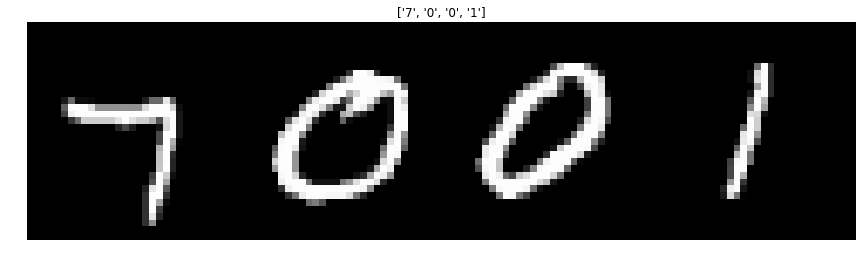

In [8]:
images, labels = show_batch_images(trainloader)

# BatchNorm

In [0]:
class MyNet(nn.Module):
  
  def __init__(self):
    super(MyNet, self).__init__()
    self.classifier = nn.Sequential(
                      nn.Linear(784, 48),  # 28 * 28
                      nn.ReLU(),
                      nn.Linear(48, 24),
                      nn.ReLU(),
                      nn.Linear(24, 10)
    )
    
  def forward(self, x):
    x = x.view(x.size(0), -1)
    #print(x.size())
    x = self.classifier(x)
    return x

In [0]:
class MyNetBN(nn.Module):
  
  def __init__(self):
    super(MyNetBN, self).__init__()
    self.classifier = nn.Sequential(
                      nn.Linear(784, 48),  # 28 * 28
                      nn.BatchNorm1d(48),
                      nn.ReLU(),
                      nn.Linear(48, 24),
                      nn.BatchNorm1d(24),
                      nn.ReLU(),
                      nn.Linear(24, 10)
    )
    
  def forward(self, x):
    x = x.view(x.size(0), -1)
    #print(x.size())
    x = self.classifier(x)
    return x

In [11]:
model = MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [12]:
model_bn = MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
batch_size = 512

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

In [0]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.001)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.001)

In [16]:
loss_arr = []
loss_bn_arr = []

max_epochs = 10

for epoch in range(max_epochs):
  
  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data
    
    opt.zero_grad()
    
    # training step for simple model
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    
    # training step for bn model
    opt_bn.zero_grad()
    outputs_bn = model_bn(inputs)
    loss_bn = loss_fn(outputs_bn, labels)
    loss_bn.backward()
    opt_bn.step()
    
    loss_arr.append(loss.item())
    loss_bn_arr.append(loss_bn.item())
    
    if i % 100 == 0:
      
      inputs = inputs.view(inputs.size(0), -1)
      
      model.eval()
      model_bn.eval()
      
      a = model.classifier[0](inputs)
      a = model.classifier[1](a)
      a = model.classifier[2](a)
      a = a.detach().numpy().ravel()
      sns.distplot(a, kde=True, color='r', label="Normal")
      
      b = model_bn.classifier[0](inputs)
      b = model_bn.classifier[1](b)
      b = model_bn.classifier[2](b)
      b = model_bn.classifier[3](b)
      b = model_bn.classifier[4](b)
      b = b.detach().numpy().ravel()
      sns.distplot(b, kde=True, color='g', label='BatchNorm')
      
      plt.title('%d : Loss = %0.2f, Loss with bn = %0.2f' % (i, loss.item(), loss_bn.item()))
      plt.legend()
      plt.show()
      plt.pause(0.5)
      
      model.train()
      model_bn.train()
      
  print('----------------------')
    
  plt.plot(loss_arr, 'r', label='Normal')
  plt.plot(loss_bn_arr, 'g', label='BatchNorm')
  plt.legend()
  plt.show()
    

KeyboardInterrupt: ignored

In [0]:
class CNN_BN(nn.Module):
  def __init__(self):
    super(CNN_BN, self).__init__()
    self.features = nn.Sequential(
                    nn.Conv2d(1, 3, 5),# (N, 1, 28, 28) -> (N, 3, 28, 28)
                    nn.ReLU(),
                    nn.AvgPool2d(2, stride=2),     # (N, 3, 28, 28) -> (N, 3, 12, 12)
                    nn.Conv2d(3, 6, 3),
                    nn.BatchNorm2d(6)              # (N, 3, 12, 12) -> (N, 6, 10, 10)
    )
    self.features1 = nn.Sequential(
                     nn.ReLU(),
                     nn.AvgPool2d(2, stride=2)     # (N, 6, 10, 10) -> (N, 6, 5, 5)
    )
    self.classifier = nn.Sequential(
                      nn.Linear(150, 25),          # (N, 150) -> (N, 25)
                      nn.ReLU(),
                      nn.Linear(25, 10)            # (N, 25) -> (N, 10)
    )
    
  def forward(self, x):
    x = self.features(x)
    x = self.features1(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

# Dropout

In [39]:
N = 25
noise = 0.3

X_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
print(X_train)
Y_train = X_train +  noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))
print(Y_train)

X_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
#print(X_train)
Y_test = X_train +  noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))
#print(Y_train)

tensor([[-1.0000],
        [-0.9167],
        [-0.8333],
        [-0.7500],
        [-0.6667],
        [-0.5833],
        [-0.5000],
        [-0.4167],
        [-0.3333],
        [-0.2500],
        [-0.1667],
        [-0.0833],
        [ 0.0000],
        [ 0.0833],
        [ 0.1667],
        [ 0.2500],
        [ 0.3333],
        [ 0.4167],
        [ 0.5000],
        [ 0.5833],
        [ 0.6667],
        [ 0.7500],
        [ 0.8333],
        [ 0.9167],
        [ 1.0000]])
tensor([[-1.2030],
        [-0.9621],
        [-0.7779],
        [-0.8557],
        [-0.5903],
        [-1.2191],
        [-0.8370],
        [-0.1814],
        [-0.8089],
        [ 0.6895],
        [ 0.1632],
        [ 0.1077],
        [-0.6699],
        [ 0.0359],
        [-0.3772],
        [-0.0276],
        [-0.1224],
        [ 0.5006],
        [ 1.0255],
        [ 0.8989],
        [ 0.7122],
        [ 0.6108],
        [ 0.9706],
        [-0.0769],
        [ 1.5766]])


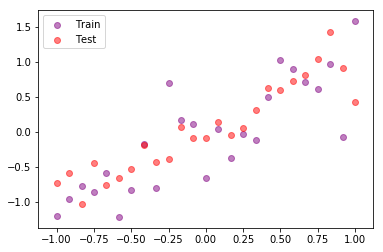

In [40]:
plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='Train')
plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='red', alpha=0.5, label='Test')
plt.legend()
plt.show()

In [0]:
N_h = 100

model = torch.nn.Sequential(
        torch.nn.Linear(1, N_h),
        torch.nn.ReLU(),
        torch.nn.Linear(N_h, N_h),
        torch.nn.ReLU(),
        torch.nn.Linear(N_h, 1)
)

model_dropout = torch.nn.Sequential(
                torch.nn.Linear(1, N_h),
                torch.nn.Dropout(0.6),
                torch.nn.ReLU(),
                torch.nn.Linear(N_h, N_h),
                torch.nn.Dropout(0.6),
                torch.nn.ReLU(),
                torch.nn.Linear(N_h, 1)
)

In [0]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)
opt_dropout = torch.optim.SGD(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

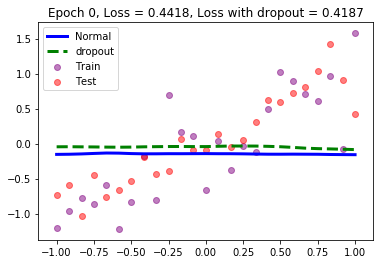

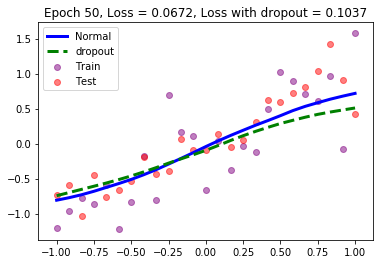

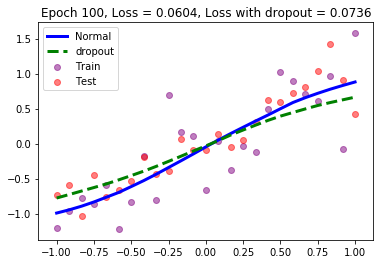

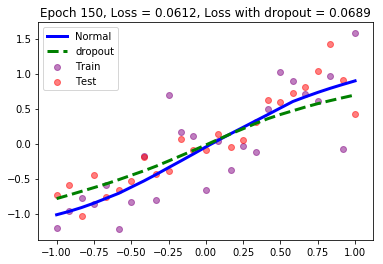

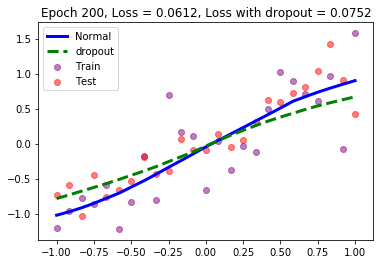

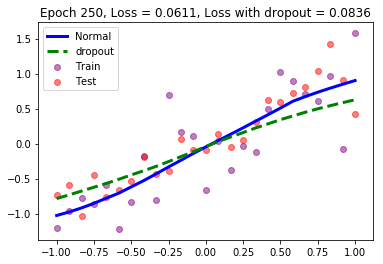

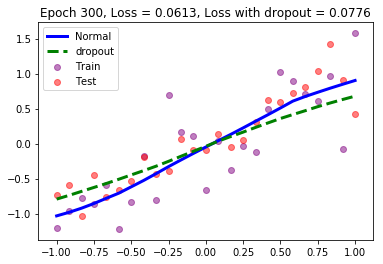

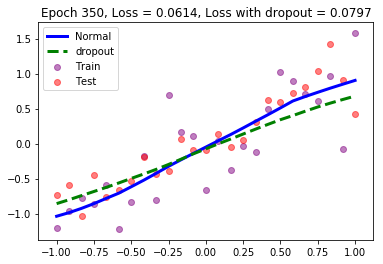

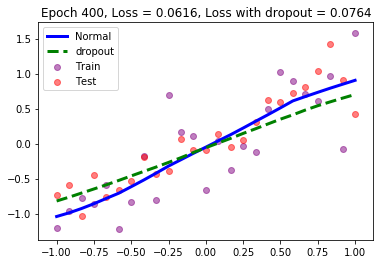

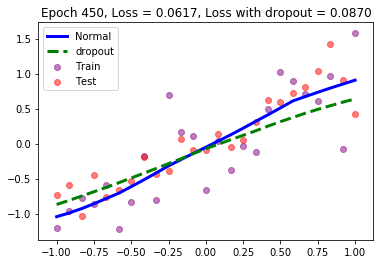

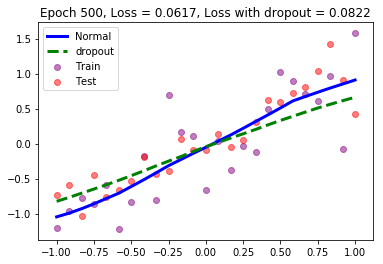

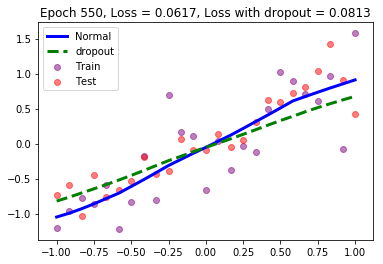

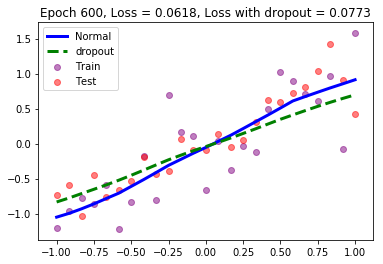

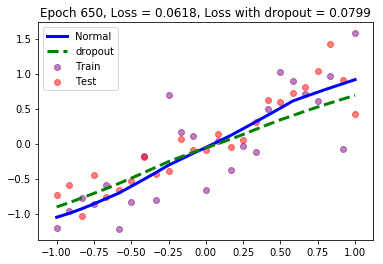

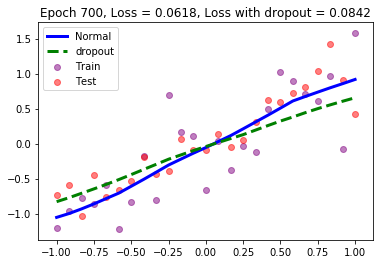

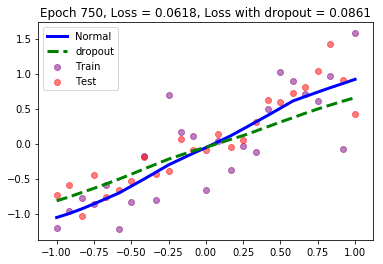

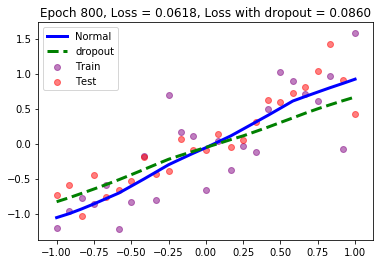

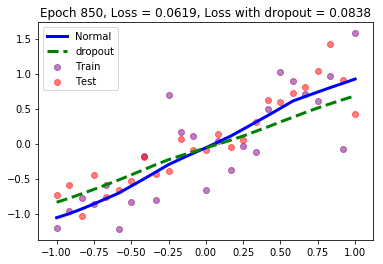

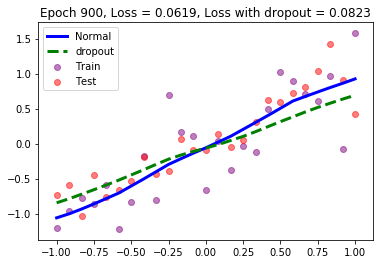

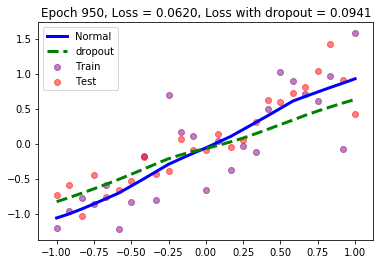

In [74]:
max_epochs = 1000

for epoch in range(max_epochs):
  
  pred = model(X_train)
  loss = loss_fn(pred, Y_train)
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  prep_dropout = model_dropout(X_train)
  loss_dropout = loss_fn(prep_dropout, Y_train)
  opt_dropout.zero_grad()
  loss_dropout.backward()
  opt_dropout.step()
  
  if epoch % 50 == 0:
    
    model.eval()
    model_dropout.eval()
    
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, Y_test)
    
    test_pred_dropout = model_dropout(X_test)
    test_loss_dropout = loss_fn(test_pred_dropout, Y_test)
    
    plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple', alpha=0.5, label='Train')
    plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='red', alpha=0.5, label='Test')
    plt.plot(X_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='Normal')
    plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3, label='dropout')
    
    plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
    
    plt.legend()
    
    model.train()
    model_dropout.train()
    
    plt.pause(0.5)